# 🤰 MamuCare — Maternal Health Risk Prediction
### Semester Project | Machine Learning Pipeline

**Goal**: Predict whether a pregnancy is **at risk (Yes)** or **not at risk (No)** using an ensemble of three ML models.

**Models Used**:
- 🌲 Random Forest Classifier
- ⚡ Gradient Boosting Classifier
- 📈 Logistic Regression
- 🗳️ Ensemble (Soft Voting)

---
**Pipeline**:
1. Import Libraries
2. Load & Explore Data
3. Preprocessing & Feature Engineering
4. EDA Visualizations
5. Train Three Models + Ensemble
6. Cross-Validation
7. Evaluation (Accuracy, F1, Confusion Matrix)
8. Feature Importance
9. Model Comparison & Save Best Model

## Block 1 — Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc
)

# Plotting style
%matplotlib inline
sns.set_theme(style='whitegrid', palette='Set2')
plt.rcParams['figure.dpi'] = 100
np.random.seed(42)

print('✅ All libraries imported successfully!')

✅ All libraries imported successfully!


## Block 2 — Load & Explore Data

In [5]:
# ── Load dataset ──────────────────────────────────────────────────────────────
df = pd.read_csv(r'C:\Users\Bhawana\Desktop\final5thsem\data\maternal_health_final.csv')

print('Dataset Shape:', df.shape)
print('\nColumn Names:', df.columns.tolist())
print('\n--- First 5 rows ---')
display(df.head())

print('\n--- Data Types ---')
print(df.dtypes)

print('\n--- Missing Values ---')
print(df.isnull().sum())

print('\n--- Target Distribution ---')
print(df['risk_level'].value_counts())

Dataset Shape: (998, 18)

Column Names: ['name', 'age', 'previous_pregnancies', 'tt_vaccine', 'gestational_age_weeks', 'weight_kg', 'height_cm', 'blood_pressure', 'anemia', 'jaundice', 'fetal_position', 'fetal_movement', 'fetal_heart_rate', 'urine_albumin', 'urine_sugar', 'vdrl_test', 'hbsag_test', 'risk_level']

--- First 5 rows ---


,name,age,previous_pregnancies,tt_vaccine,gestational_age_weeks,weight_kg,height_cm,blood_pressure,anemia,jaundice,fetal_position,fetal_movement,fetal_heart_rate,urine_albumin,urine_sugar,vdrl_test,hbsag_test,risk_level
0,Rituporna,18,1st,1st,38 week,50 kg,5.3'',100/60,NaN,NaN,Normal,Normal,140m,NaN,Yes,Negative,Negative,Yes
1,Moina,25,2nd,2nd,38 week,60 kg,5.2'',100/70,NaN,NaN,Normal,Normal,130m,NaN,Yes,Positive,Negative,No
2,Rabeya,20,1st,1st,30 week,55 kg,5.0'',100/60,NaN,NaN,Normal,Normal,120m,NaN,Yes,Negative,Negative,Yes
3,Shorna,22,1st,3rd,35 week,51 kg,5.4'',110/65,NaN,NaN,Normal,Normal,130m,NaN,Yes,Positive,Negative,Yes
4,Tania Akter,20,1st,2nd,30 week,53 kg,5.2'',100/55,NaN,NaN,Normal,Normal,125m,NaN,Yes,Negative,Negative,No



--- Data Types ---
name                       str
age                      int64
previous_pregnancies       str
tt_vaccine                 str
gestational_age_weeks      str
weight_kg                  str
height_cm                  str
blood_pressure             str
anemia                     str
jaundice                   str
fetal_position             str
fetal_movement             str
fetal_heart_rate           str
urine_albumin              str
urine_sugar                str
vdrl_test                  str
hbsag_test                 str
risk_level                 str
dtype: object

--- Missing Values ---
name                       0
age                        0
previous_pregnancies       0
tt_vaccine                 0
gestational_age_weeks      0
weight_kg                  0
height_cm                  0
blood_pressure             0
anemia                   875
jaundice                 986
fetal_position             0
fetal_movement             0
fetal_heart_rate           0
urine_a

## Block 3 — Data Preprocessing & Feature Engineering

Raw columns contain messy strings like `'38 week'`, `'50 kg'`, `'5.3''` and `'100/60'`.
We parse all of them into clean numeric values.

In [6]:
# ── Work on a copy ────────────────────────────────────────────────────────────
data = df.copy()

# ── Drop irrelevant identifier column ─────────────────────────────────────────
data.drop(columns=['name'], inplace=True)

# ── Parse gestational_age_weeks  (e.g. '38 week' → 38) ────────────────────────
data['gestational_age_weeks'] = data['gestational_age_weeks'].str.extract(r'(\d+)').astype(float)

# ── Parse weight_kg  (e.g. '50 kg' → 50) ─────────────────────────────────────
data['weight_kg'] = data['weight_kg'].str.extract(r'([\d.]+)').astype(float)

# ── Parse height_cm  (stored as feet like '5.3\'' → convert to cm) ────────────
def feet_to_cm(val):
    """Convert '5.3\'' style height string to centimetres."""
    try:
        val = str(val).replace("'", "").strip()
        parts = val.split('.')
        feet = int(parts[0])
        inches = int(parts[1]) if len(parts) > 1 else 0
        return round((feet * 12 + inches) * 2.54, 1)
    except:
        return np.nan

data['height_cm'] = data['height_cm'].apply(feet_to_cm)

# ── Parse blood_pressure  ('100/60' → systolic=100, diastolic=60) ─────────────
bp_split = data['blood_pressure'].str.extract(r'(\d+)/(\d+)')
data['systolic_bp']  = pd.to_numeric(bp_split[0], errors='coerce')
data['diastolic_bp'] = pd.to_numeric(bp_split[1], errors='coerce')
data.drop(columns=['blood_pressure'], inplace=True)

# ── Parse fetal_heart_rate  ('140m' → 140) ────────────────────────────────────
data['fetal_heart_rate'] = data['fetal_heart_rate'].str.extract(r'(\d+)').astype(float)

# ── Ordinal encode previous_pregnancies & tt_vaccine  ('1st'→1, '2nd'→2, '3rd'→3)
ordinal_map = {'1st': 1, '2nd': 2, '3rd': 3}
data['previous_pregnancies'] = data['previous_pregnancies'].map(ordinal_map)
data['tt_vaccine']           = data['tt_vaccine'].map(ordinal_map)

# ── Ordinal encode anemia / jaundice / urine_albumin ──────────────────────────
severity_map = {'Minimal': 1, 'Medium': 2, 'Higher': 3}
for col in ['anemia', 'jaundice', 'urine_albumin']:
    data[col] = data[col].map(severity_map)

# ── Binary encode yes/no & positive/negative columns ──────────────────────────
binary_map_yn  = {'Yes': 1, 'No': 0}
binary_map_pn  = {'Positive': 1, 'Negative': 0}
normal_map     = {'Normal': 0, 'Abnormal': 1}

data['urine_sugar']    = data['urine_sugar'].map(binary_map_yn)
data['vdrl_test']      = data['vdrl_test'].map(binary_map_pn)
data['hbsag_test']     = data['hbsag_test'].map(binary_map_pn)
data['fetal_position'] = data['fetal_position'].map(normal_map)
data['fetal_movement'] = data['fetal_movement'].map(normal_map)

# ── Encode target: Yes (risk) → 1, No → 0 ─────────────────────────────────────
data['risk_level'] = data['risk_level'].map({'Yes': 1, 'No': 0})

# ── BMI feature (derived) ─────────────────────────────────────────────────────
data['bmi'] = (data['weight_kg'] / ((data['height_cm'] / 100) ** 2)).round(2)

# ── Fill any remaining NaN with column median ─────────────────────────────────
data.fillna(data.median(numeric_only=True), inplace=True)

print('✅ Preprocessing complete!')
print(f'Final shape: {data.shape}')
display(data.head())
print('\n--- Cleaned Data Info ---')
data.info()

✅ Preprocessing complete!
Final shape: (998, 19)


,age,previous_pregnancies,tt_vaccine,gestational_age_weeks,weight_kg,height_cm,anemia,jaundice,fetal_position,fetal_movement,fetal_heart_rate,urine_albumin,urine_sugar,vdrl_test,hbsag_test,risk_level,systolic_bp,diastolic_bp,bmi
0,18,1,1,38.0,50.0,160.0,1.0,1.0,0,0,140.0,2.0,1,0,0,1,100,60,19.53
1,25,2,2,38.0,60.0,157.5,1.0,1.0,0,0,130.0,2.0,1,1,0,0,100,70,24.19
2,20,1,1,30.0,55.0,152.4,1.0,1.0,0,0,120.0,2.0,1,0,0,1,100,60,23.68
3,22,1,3,35.0,51.0,162.6,1.0,1.0,0,0,130.0,2.0,1,1,0,1,110,65,19.29
4,20,1,2,30.0,53.0,157.5,1.0,1.0,0,0,125.0,2.0,1,0,0,0,100,55,21.37



--- Cleaned Data Info ---
<class 'pandas.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   age                    998 non-null    int64  
 1   previous_pregnancies   998 non-null    int64  
 2   tt_vaccine             998 non-null    int64  
 3   gestational_age_weeks  998 non-null    float64
 4   weight_kg              998 non-null    float64
 5   height_cm              998 non-null    float64
 6   anemia                 998 non-null    float64
 7   jaundice               998 non-null    float64
 8   fetal_position         998 non-null    int64  
 9   fetal_movement         998 non-null    int64  
 10  fetal_heart_rate       998 non-null    float64
 11  urine_albumin          998 non-null    float64
 12  urine_sugar            998 non-null    int64  
 13  vdrl_test              998 non-null    int64  
 14  hbsag_test             998 non-null    int

## Block 4 — Exploratory Data Analysis (EDA)

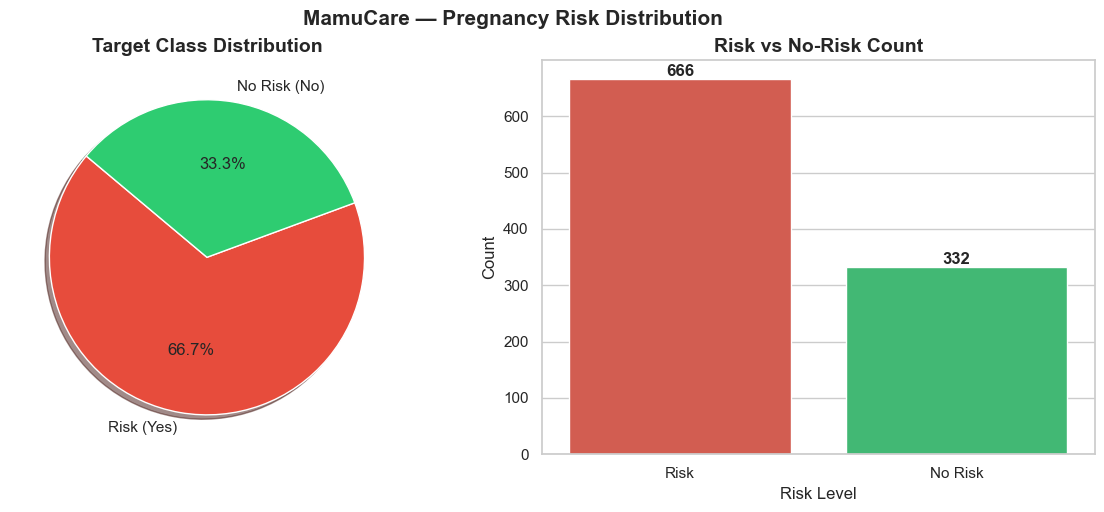

Risk=1 (at risk pregnancies): 666
Risk=0 (safe pregnancies)   : 332


In [7]:
# ── 4a. Target Class Distribution ─────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

risk_counts = data['risk_level'].value_counts()
labels = ['Risk (Yes)', 'No Risk (No)']
colors = ['#e74c3c', '#2ecc71']

axes[0].pie(risk_counts, labels=labels, colors=colors, autopct='%1.1f%%',
            startangle=140, shadow=True)
axes[0].set_title('Target Class Distribution', fontsize=14, fontweight='bold')

sns.countplot(x=data['risk_level'].map({1: 'Risk', 0: 'No Risk'}),
              palette={'Risk': '#e74c3c', 'No Risk': '#2ecc71'}, ax=axes[1])
axes[1].set_title('Risk vs No-Risk Count', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Risk Level')
axes[1].set_ylabel('Count')
for p in axes[1].patches:
    axes[1].annotate(f'{int(p.get_height())}',
                     (p.get_x() + p.get_width()/2, p.get_height()),
                     ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.suptitle('MamuCare — Pregnancy Risk Distribution', y=1.02, fontsize=15, fontweight='bold')
plt.savefig('plot_01_target_distribution.png', bbox_inches='tight')
plt.show()
print('Risk=1 (at risk pregnancies):', risk_counts.get(1, 0))
print('Risk=0 (safe pregnancies)   :', risk_counts.get(0, 0))

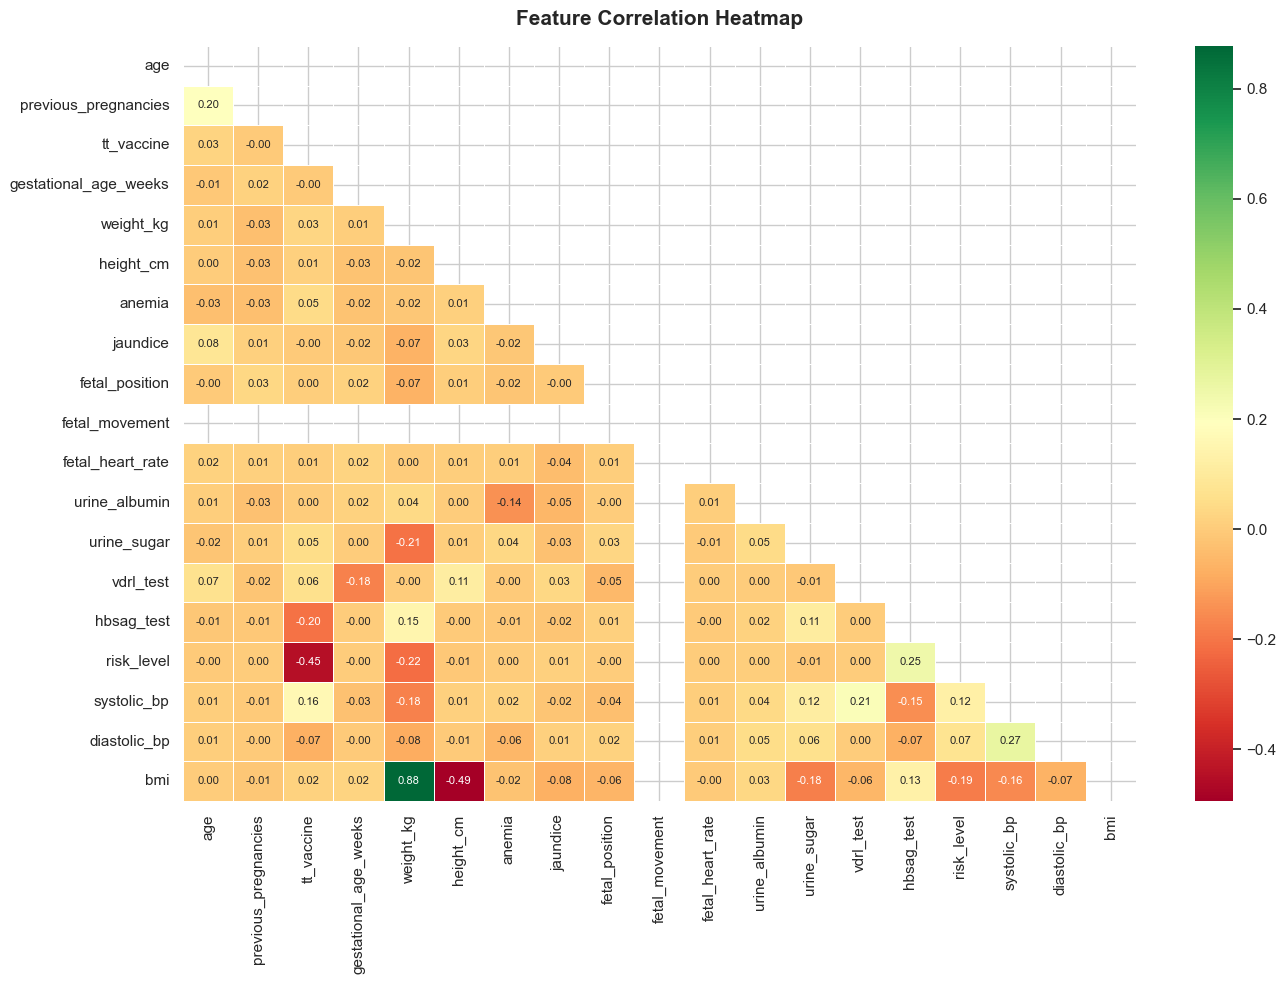

In [8]:
# ── 4b. Correlation Heatmap ───────────────────────────────────────────────────
plt.figure(figsize=(14, 10))
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='RdYlGn',
            linewidths=0.5, annot_kws={'size': 8})
plt.title('Feature Correlation Heatmap', fontsize=15, fontweight='bold', pad=15)
plt.tight_layout()
plt.savefig('plot_02_correlation_heatmap.png', bbox_inches='tight')
plt.show()

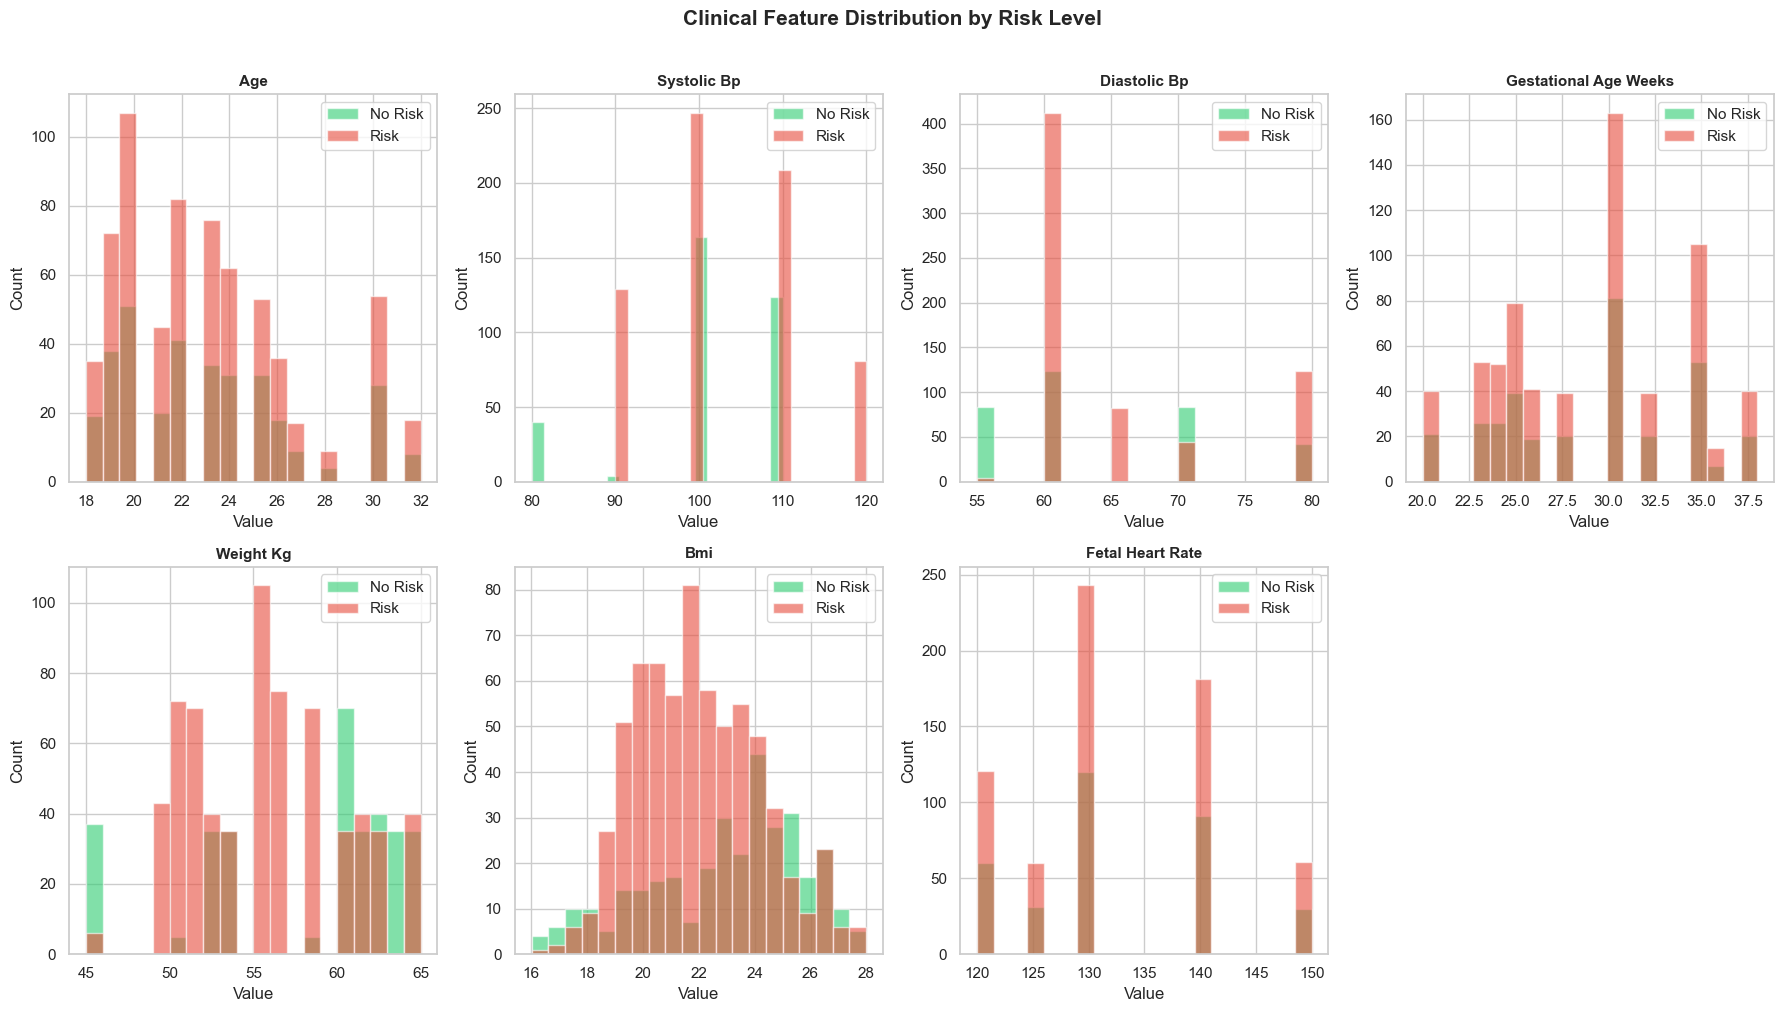

In [9]:
# ── 4c. Key Clinical Features vs Risk Level ───────────────────────────────────
clinical_features = ['age', 'systolic_bp', 'diastolic_bp', 'gestational_age_weeks',
                     'weight_kg', 'bmi', 'fetal_heart_rate']

fig, axes = plt.subplots(2, 4, figsize=(18, 10))
axes = axes.flatten()

for i, feat in enumerate(clinical_features):
    for risk_val, color, label in [(0, '#2ecc71', 'No Risk'), (1, '#e74c3c', 'Risk')]:
        subset = data[data['risk_level'] == risk_val][feat].dropna()
        axes[i].hist(subset, bins=20, alpha=0.6, color=color, label=label, edgecolor='white')
    axes[i].set_title(feat.replace('_', ' ').title(), fontsize=11, fontweight='bold')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Count')
    axes[i].legend()

axes[-1].axis('off')  # hide last empty cell
plt.suptitle('Clinical Feature Distribution by Risk Level', fontsize=15, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('plot_03_feature_distributions.png', bbox_inches='tight')
plt.show()

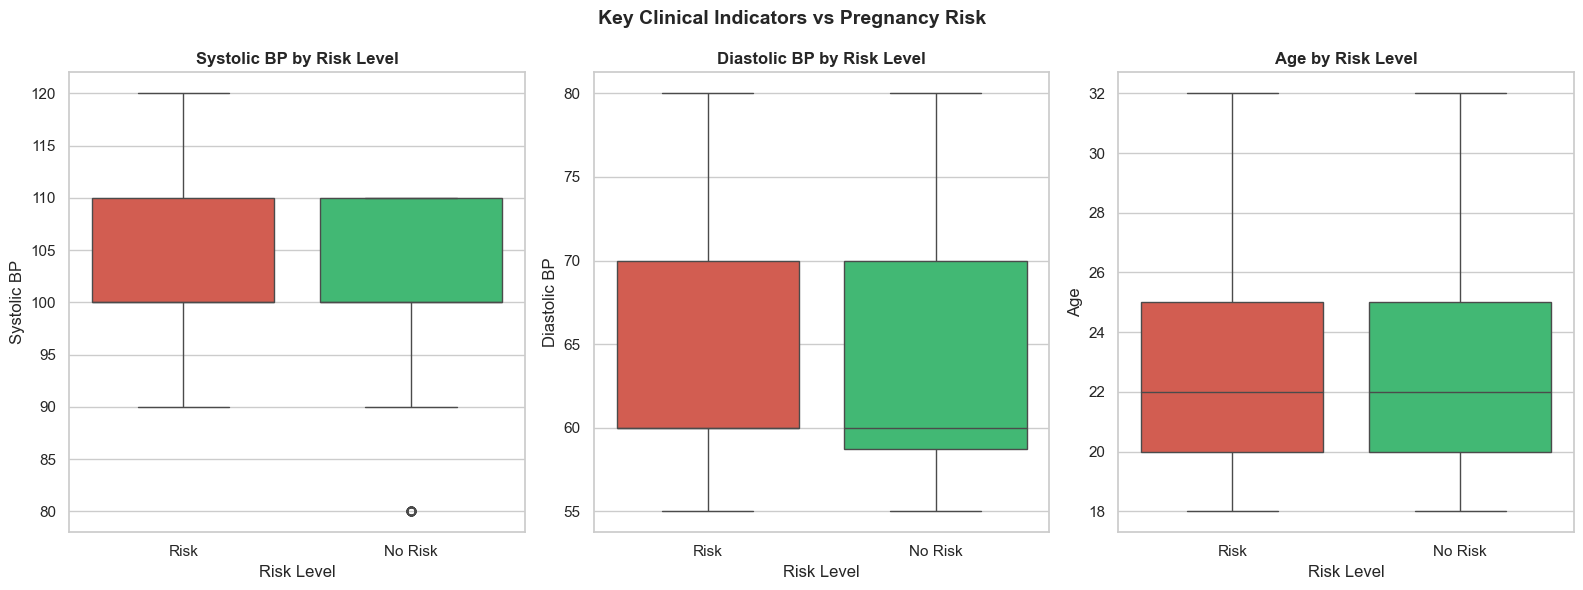

In [10]:
# ── 4d. Box Plots — BP & Age by Risk ─────────────────────────────────────────
plot_data = data.copy()
plot_data['risk_label'] = plot_data['risk_level'].map({1: 'Risk', 0: 'No Risk'})

fig, axes = plt.subplots(1, 3, figsize=(16, 6))

for ax, feat, title in zip(axes,
                            ['systolic_bp', 'diastolic_bp', 'age'],
                            ['Systolic BP', 'Diastolic BP', 'Age']):
    sns.boxplot(x='risk_label', y=feat, data=plot_data,
                palette={'Risk': '#e74c3c', 'No Risk': '#2ecc71'}, ax=ax)
    ax.set_title(f'{title} by Risk Level', fontsize=12, fontweight='bold')
    ax.set_xlabel('Risk Level')
    ax.set_ylabel(title)

plt.suptitle('Key Clinical Indicators vs Pregnancy Risk', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('plot_04_boxplots.png', bbox_inches='tight')
plt.show()

## Block 5 — Feature Selection & Train/Test Split

In [11]:
# ── Define feature matrix X and target y ──────────────────────────────────────
X = data.drop(columns=['risk_level'])
y = data['risk_level']

feature_names = X.columns.tolist()

print('Features used for training:')
for i, f in enumerate(feature_names, 1):
    print(f'  {i:2d}. {f}')

print(f'\nTotal features : {len(feature_names)}')
print(f'Total samples  : {len(y)}')

# ── Stratified 80/20 split ────────────────────────────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# ── Scale features (important for Logistic Regression) ───────────────────────
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)

print(f'\nTrain size: {X_train.shape[0]} samples')
print(f'Test  size: {X_test.shape[0]} samples')
print(f'Train class balance — Risk:{y_train.sum()} | No-Risk:{(y_train==0).sum()}')
print(f'Test  class balance — Risk:{y_test.sum()}  | No-Risk:{(y_test==0).sum()}')

Features used for training:
   1. age
   2. previous_pregnancies
   3. tt_vaccine
   4. gestational_age_weeks
   5. weight_kg
   6. height_cm
   7. anemia
   8. jaundice
   9. fetal_position
  10. fetal_movement
  11. fetal_heart_rate
  12. urine_albumin
  13. urine_sugar
  14. vdrl_test
  15. hbsag_test
  16. systolic_bp
  17. diastolic_bp
  18. bmi

Total features : 18
Total samples  : 998

Train size: 798 samples
Test  size: 200 samples
Train class balance — Risk:533 | No-Risk:265
Test  class balance — Risk:133  | No-Risk:67


## Block 6 — Train Three Individual Models

In [12]:
# ════════════════════════════════════════════════════════════════════════════════
# 6a. Model 1 — Random Forest Classifier
# ════════════════════════════════════════════════════════════════════════════════
print('=' * 55)
print('  MODEL 1 — Random Forest Classifier')
print('=' * 55)

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42
)
rf_model.fit(X_train, y_train)          # RF does NOT need scaled data
rf_pred = rf_model.predict(X_test)

rf_metrics = {
    'Model'     : 'Random Forest',
    'Accuracy'  : round(accuracy_score(y_test, rf_pred), 4),
    'Precision' : round(precision_score(y_test, rf_pred, zero_division=0), 4),
    'Recall'    : round(recall_score(y_test, rf_pred, zero_division=0), 4),
    'F1-Score'  : round(f1_score(y_test, rf_pred, zero_division=0), 4)
}
print('\nClassification Report:')
print(classification_report(y_test, rf_pred, target_names=['No Risk', 'Risk']))
print('Metrics:', rf_metrics)

  MODEL 1 — Random Forest Classifier

Classification Report:
              precision    recall  f1-score   support

     No Risk       0.94      0.90      0.92        67
        Risk       0.95      0.97      0.96       133

    accuracy                           0.94       200
   macro avg       0.94      0.93      0.94       200
weighted avg       0.94      0.94      0.94       200

Metrics: {'Model': 'Random Forest', 'Accuracy': 0.945, 'Precision': 0.9485, 'Recall': 0.9699, 'F1-Score': 0.9591}


In [13]:
# ════════════════════════════════════════════════════════════════════════════════
# 6b. Model 2 — Gradient Boosting Classifier
# ════════════════════════════════════════════════════════════════════════════════
print('=' * 55)
print('  MODEL 2 — Gradient Boosting Classifier')
print('=' * 55)

gbc_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.08,
    max_depth=4,
    subsample=0.8,
    random_state=42
)
gbc_model.fit(X_train, y_train)         # GBC also works on raw features
gbc_pred = gbc_model.predict(X_test)

gbc_metrics = {
    'Model'     : 'Gradient Boosting',
    'Accuracy'  : round(accuracy_score(y_test, gbc_pred), 4),
    'Precision' : round(precision_score(y_test, gbc_pred, zero_division=0), 4),
    'Recall'    : round(recall_score(y_test, gbc_pred, zero_division=0), 4),
    'F1-Score'  : round(f1_score(y_test, gbc_pred, zero_division=0), 4)
}
print('\nClassification Report:')
print(classification_report(y_test, gbc_pred, target_names=['No Risk', 'Risk']))
print('Metrics:', gbc_metrics)

  MODEL 2 — Gradient Boosting Classifier

Classification Report:
              precision    recall  f1-score   support

     No Risk       0.96      0.97      0.96        67
        Risk       0.98      0.98      0.98       133

    accuracy                           0.97       200
   macro avg       0.97      0.97      0.97       200
weighted avg       0.98      0.97      0.98       200

Metrics: {'Model': 'Gradient Boosting', 'Accuracy': 0.975, 'Precision': 0.9848, 'Recall': 0.9774, 'F1-Score': 0.9811}


In [14]:
# ════════════════════════════════════════════════════════════════════════════════
# 6c. Model 3 — Logistic Regression
# ════════════════════════════════════════════════════════════════════════════════
print('=' * 55)
print('  MODEL 3 — Logistic Regression')
print('=' * 55)

lr_model = LogisticRegression(
    C=1.0,
    max_iter=1000,
    class_weight='balanced',
    solver='lbfgs',
    random_state=42
)
lr_model.fit(X_train_sc, y_train)       # LR NEEDS scaled data
lr_pred = lr_model.predict(X_test_sc)

lr_metrics = {
    'Model'     : 'Logistic Regression',
    'Accuracy'  : round(accuracy_score(y_test, lr_pred), 4),
    'Precision' : round(precision_score(y_test, lr_pred, zero_division=0), 4),
    'Recall'    : round(recall_score(y_test, lr_pred, zero_division=0), 4),
    'F1-Score'  : round(f1_score(y_test, lr_pred, zero_division=0), 4)
}
print('\nClassification Report:')
print(classification_report(y_test, lr_pred, target_names=['No Risk', 'Risk']))
print('Metrics:', lr_metrics)

  MODEL 3 — Logistic Regression

Classification Report:
              precision    recall  f1-score   support

     No Risk       0.56      0.66      0.61        67
        Risk       0.81      0.74      0.78       133

    accuracy                           0.71       200
   macro avg       0.69      0.70      0.69       200
weighted avg       0.73      0.71      0.72       200

Metrics: {'Model': 'Logistic Regression', 'Accuracy': 0.715, 'Precision': 0.8115, 'Recall': 0.7444, 'F1-Score': 0.7765}


## Block 7 — Ensemble Model (Soft Voting)

We wrap each model inside a Pipeline so the VotingClassifier can handle **both scaled and unscaled** data uniformly.

In [15]:
# ════════════════════════════════════════════════════════════════════════════════
# 7. Soft Voting Ensemble
#    Each sub-model is wrapped in a Pipeline to handle scaling internally.
#    This ensures the VotingClassifier receives raw X_train/X_test.
# ════════════════════════════════════════════════════════════════════════════════
print('=' * 55)
print('  ENSEMBLE — Soft Voting Classifier')
print('=' * 55)

# Define base estimators as Pipelines
pipe_rf = Pipeline([('clf', RandomForestClassifier(
    n_estimators=200, max_depth=10, min_samples_split=5,
    min_samples_leaf=2, class_weight='balanced', random_state=42
))])

pipe_gbc = Pipeline([('clf', GradientBoostingClassifier(
    n_estimators=200, learning_rate=0.08, max_depth=4,
    subsample=0.8, random_state=42
))])

pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(
        C=1.0, max_iter=1000, class_weight='balanced',
        solver='lbfgs', random_state=42
    ))
])

# Soft voting — averages predicted probabilities
ensemble = VotingClassifier(
    estimators=[
        ('rf',  pipe_rf),
        ('gbc', pipe_gbc),
        ('lr',  pipe_lr)
    ],
    voting='soft',
    weights=[2, 2, 1]   # give tree models slightly more weight
)

ensemble.fit(X_train, y_train)
ens_pred = ensemble.predict(X_test)

ens_metrics = {
    'Model'     : 'Ensemble (Soft Voting)',
    'Accuracy'  : round(accuracy_score(y_test, ens_pred), 4),
    'Precision' : round(precision_score(y_test, ens_pred, zero_division=0), 4),
    'Recall'    : round(recall_score(y_test, ens_pred, zero_division=0), 4),
    'F1-Score'  : round(f1_score(y_test, ens_pred, zero_division=0), 4)
}
print('\nClassification Report:')
print(classification_report(y_test, ens_pred, target_names=['No Risk', 'Risk']))
print('Metrics:', ens_metrics)

  ENSEMBLE — Soft Voting Classifier

Classification Report:
              precision    recall  f1-score   support

     No Risk       0.94      0.97      0.96        67
        Risk       0.98      0.97      0.98       133

    accuracy                           0.97       200
   macro avg       0.96      0.97      0.97       200
weighted avg       0.97      0.97      0.97       200

Metrics: {'Model': 'Ensemble (Soft Voting)', 'Accuracy': 0.97, 'Precision': 0.9847, 'Recall': 0.9699, 'F1-Score': 0.9773}


## Block 8 — 5-Fold Cross-Validation

Cross-Validation Results (F1-Score):
-------------------------------------------------------
Random Forest           Mean F1: 0.9539  ± 0.0070
Gradient Boosting       Mean F1: 0.9736  ± 0.0098
Logistic Regression     Mean F1: 0.7987  ± 0.0341
Ensemble                Mean F1: 0.9726  ± 0.0059


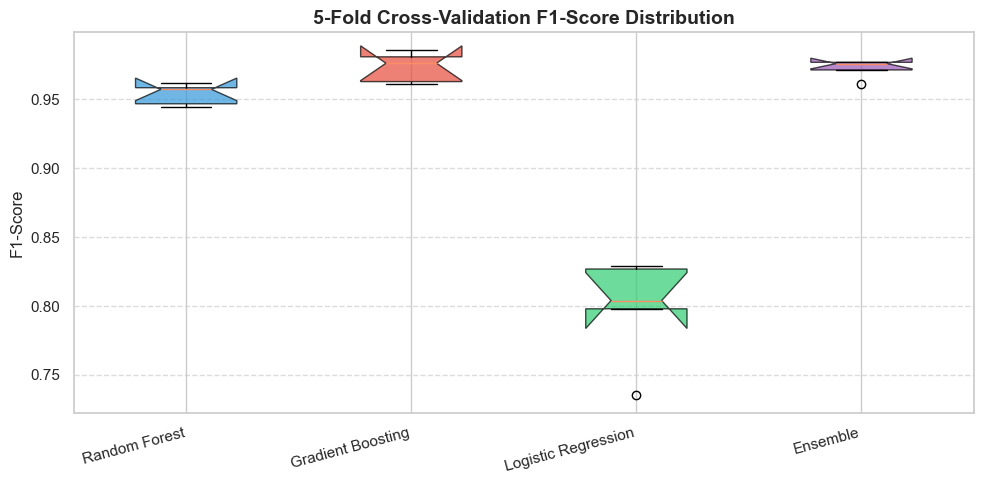

In [16]:
# ── 5-Fold Stratified Cross Validation ───────────────────────────────────────
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models_for_cv = {
    'Random Forest'       : (rf_model,  X_train),
    'Gradient Boosting'   : (gbc_model, X_train),
    'Logistic Regression' : (lr_model,  X_train_sc),
    'Ensemble'            : (ensemble,  X_train)
}

cv_results = {}
print('Cross-Validation Results (F1-Score):')
print('-' * 55)

for name, (model, X_data) in models_for_cv.items():
    scores = cross_val_score(model, X_data, y_train,
                             cv=cv, scoring='f1', n_jobs=-1)
    cv_results[name] = scores
    print(f'{name:22s}  Mean F1: {scores.mean():.4f}  ± {scores.std():.4f}')

# ── Plot CV results ───────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 5))

positions = range(len(cv_results))
bp = ax.boxplot(cv_results.values(), positions=positions, patch_artist=True,
                notch=True, vert=True)

colors_cv = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6']
for patch, color in zip(bp['boxes'], colors_cv):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_xticks(list(positions))
ax.set_xticklabels(cv_results.keys(), rotation=15, ha='right')
ax.set_ylabel('F1-Score', fontsize=12)
ax.set_title('5-Fold Cross-Validation F1-Score Distribution', fontsize=14, fontweight='bold')
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('plot_05_cross_validation.png', bbox_inches='tight')
plt.show()

## Block 9 — Confusion Matrices (All Models)

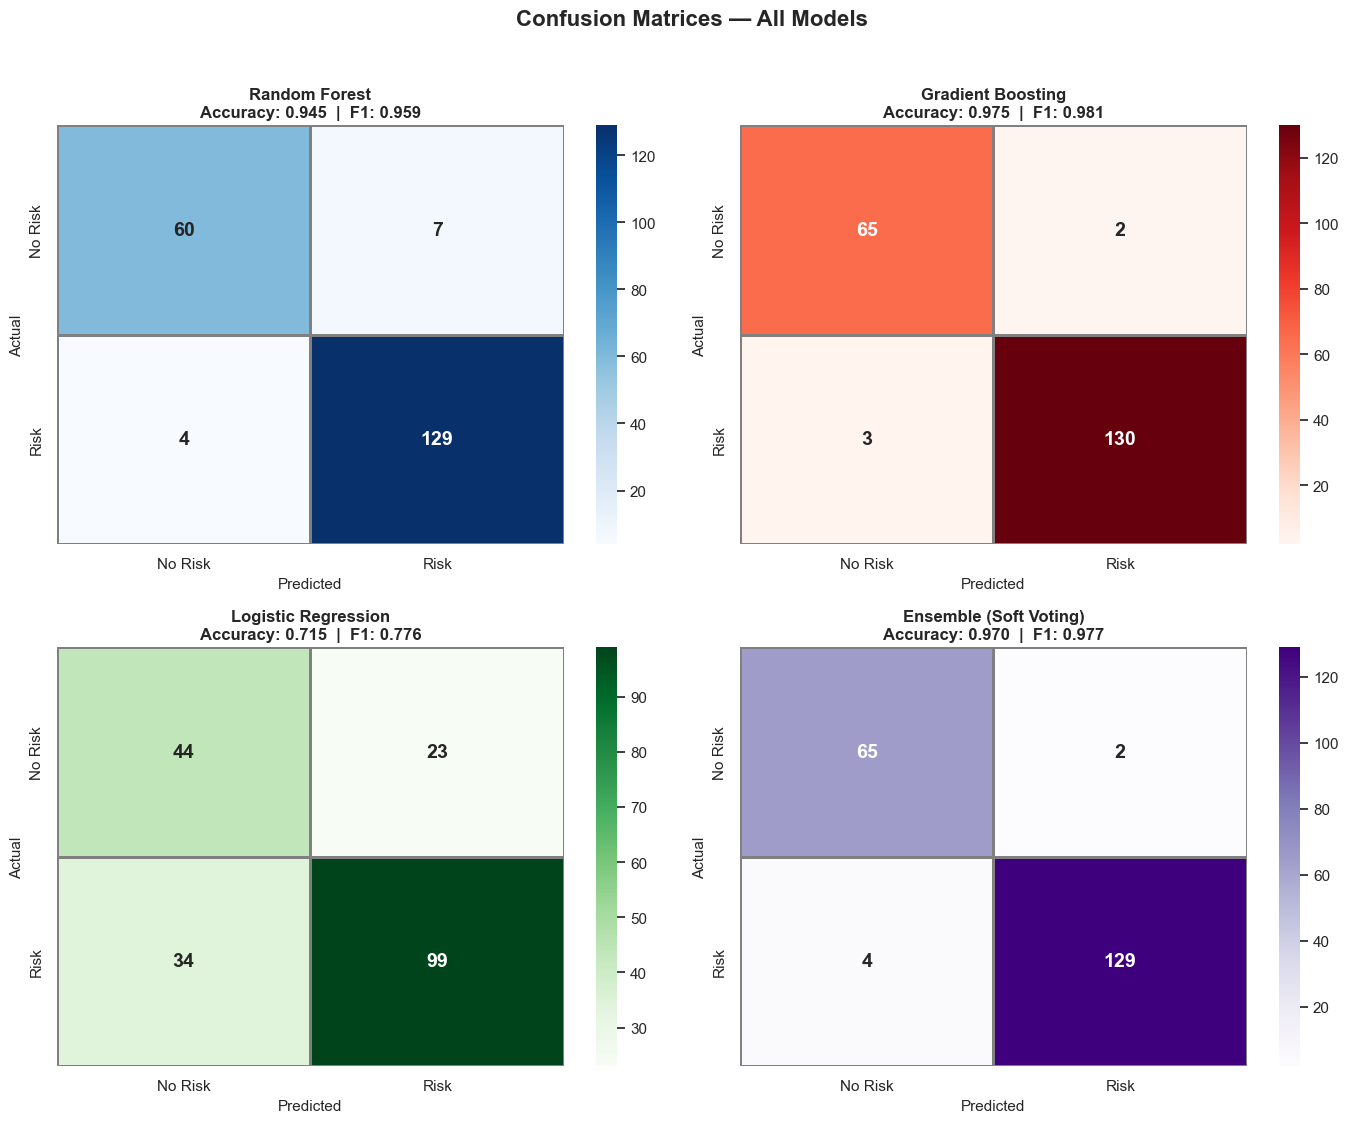

In [17]:
# ── Confusion matrices for all four models side-by-side ──────────────────────
all_preds = {
    'Random Forest'       : rf_pred,
    'Gradient Boosting'   : gbc_pred,
    'Logistic Regression' : lr_pred,
    'Ensemble (Soft Voting)': ens_pred
}

class_labels = ['No Risk', 'Risk']
cmaps = ['Blues', 'Reds', 'Greens', 'Purples']

fig, axes = plt.subplots(2, 2, figsize=(14, 11))
axes = axes.flatten()

for idx, (name, pred) in enumerate(all_preds.items()):
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmaps[idx],
                xticklabels=class_labels, yticklabels=class_labels,
                linewidths=1, linecolor='gray', annot_kws={'size': 14, 'weight': 'bold'},
                ax=axes[idx])
    acc = accuracy_score(y_test, pred)
    f1  = f1_score(y_test, pred, zero_division=0)
    axes[idx].set_title(f'{name}\nAccuracy: {acc:.3f}  |  F1: {f1:.3f}',
                        fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Actual',    fontsize=11)
    axes[idx].set_xlabel('Predicted', fontsize=11)

plt.suptitle('Confusion Matrices — All Models', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('plot_06_confusion_matrices.png', bbox_inches='tight')
plt.show()

## Block 10 — ROC Curves

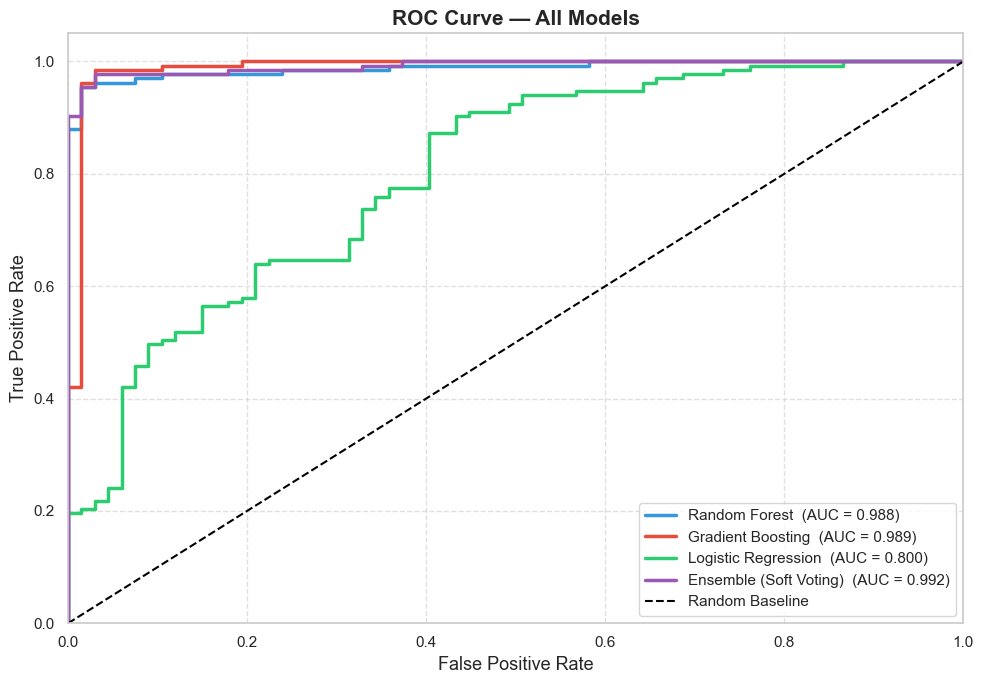

In [18]:
# ── ROC-AUC curves for all models ────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 7))

roc_colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6']

prob_sources = {
    'Random Forest'         : (rf_model,  X_test),
    'Gradient Boosting'     : (gbc_model, X_test),
    'Logistic Regression'   : (lr_model,  X_test_sc),
    'Ensemble (Soft Voting)': (ensemble,  X_test)
}

for (name, (model, X_data)), color in zip(prob_sources.items(), roc_colors):
    proba = model.predict_proba(X_data)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, proba)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color=color, lw=2.5,
            label=f'{name}  (AUC = {roc_auc:.3f})')

ax.plot([0, 1], [0, 1], 'k--', lw=1.5, label='Random Baseline')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=13)
ax.set_ylabel('True Positive Rate',  fontsize=13)
ax.set_title('ROC Curve — All Models', fontsize=15, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig('plot_07_roc_curves.png', bbox_inches='tight')
plt.show()

## Block 11 — Model Comparison Table & Bar Chart

📊 Model Performance Comparison:


,Accuracy,Precision,Recall,F1-Score
Model,,,,
Random Forest,0.9450,0.9485,0.9699,0.9591
Gradient Boosting,0.9750,0.9848,0.9774,0.9811
Logistic Regression,0.7150,0.8115,0.7444,0.7765
Ensemble (Soft Voting),0.9700,0.9847,0.9699,0.9773



🏆 Best Model by F1-Score: Gradient Boosting
Accuracy     0.9750
Precision    0.9848
Recall       0.9774
F1-Score     0.9811
Name: Gradient Boosting, dtype: float64


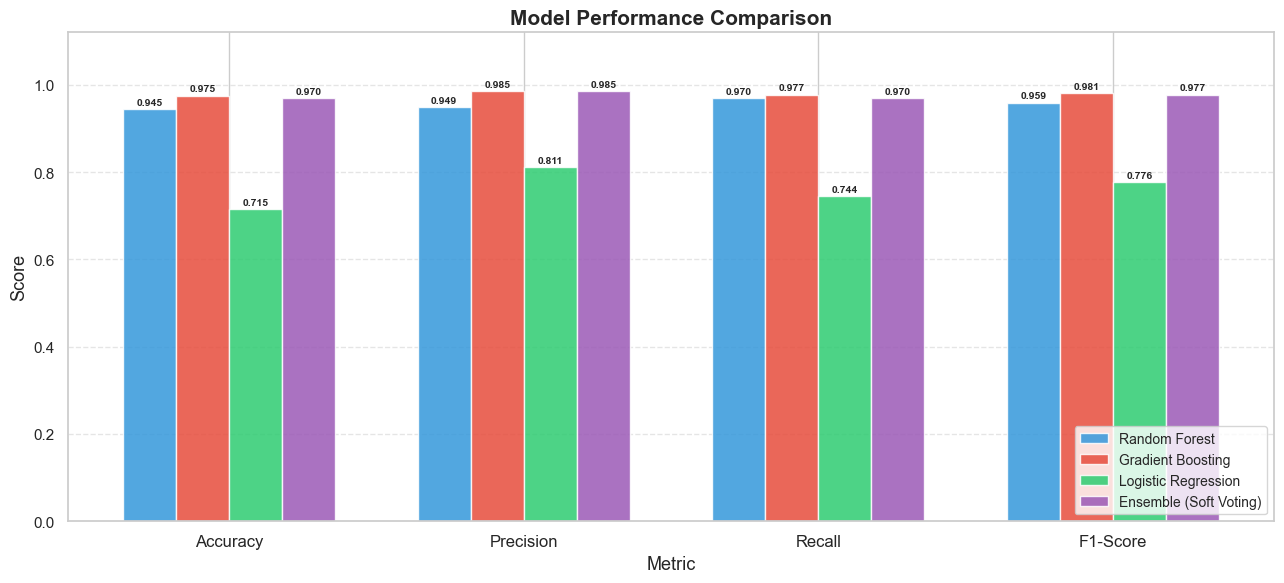

In [19]:
# ── Build comparison DataFrame ────────────────────────────────────────────────
results_df = pd.DataFrame([rf_metrics, gbc_metrics, lr_metrics, ens_metrics])
results_df = results_df.set_index('Model')

print('📊 Model Performance Comparison:')
print('=' * 65)
display(results_df.style
        .highlight_max(axis=0, color='#d5f5e3')   # green = best per metric
        .format('{:.4f}'))

# Best model by F1-Score
best_model_name = results_df['F1-Score'].idxmax()
print(f'\n🏆 Best Model by F1-Score: {best_model_name}')
print(results_df.loc[best_model_name])

# ── Grouped bar chart ─────────────────────────────────────────────────────────
metrics_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(metrics_plot))
width = 0.18
model_list = results_df.index.tolist()
bar_colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6']

fig, ax = plt.subplots(figsize=(13, 6))
for i, (model_name, color) in enumerate(zip(model_list, bar_colors)):
    values = [results_df.loc[model_name, m] for m in metrics_plot]
    bars = ax.bar(x + i * width, values, width, label=model_name,
                  color=color, alpha=0.85, edgecolor='white')
    for bar in bars:
        ax.text(bar.get_x() + bar.get_width() / 2,
                bar.get_height() + 0.005,
                f'{bar.get_height():.3f}',
                ha='center', va='bottom', fontsize=7.5, fontweight='bold')

ax.set_xlabel('Metric', fontsize=13)
ax.set_ylabel('Score', fontsize=13)
ax.set_title('Model Performance Comparison', fontsize=15, fontweight='bold')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(metrics_plot, fontsize=12)
ax.set_ylim(0, 1.12)
ax.legend(fontsize=10, loc='lower right')
ax.grid(True, axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('plot_08_model_comparison.png', bbox_inches='tight')
plt.show()

## Block 12 — Feature Importance

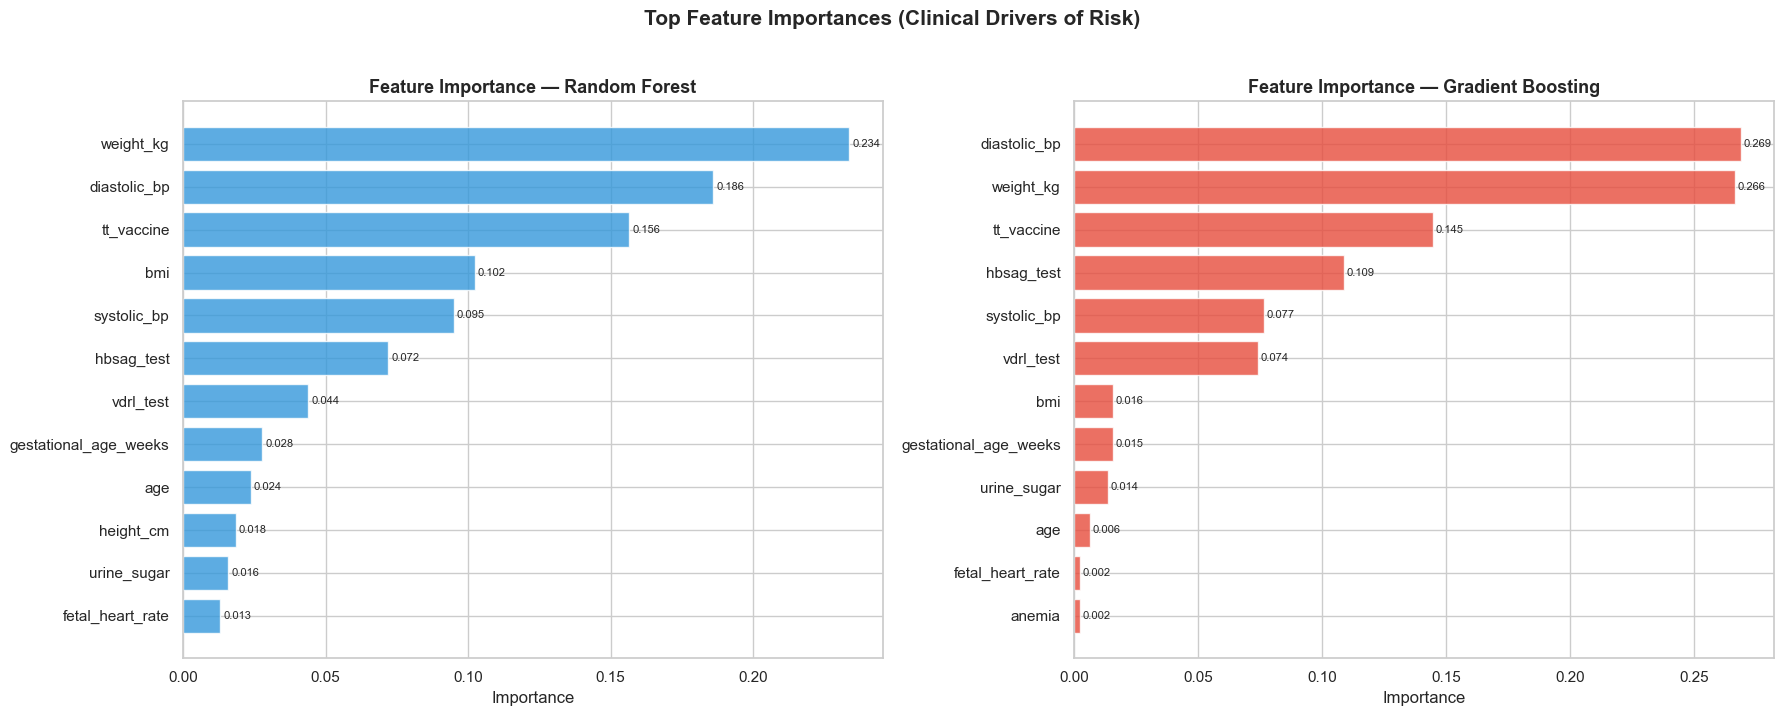


🔍 Top driver (Random Forest)     : weight_kg
🔍 Top driver (Gradient Boosting)  : diastolic_bp


In [20]:
# ── Feature importance from both tree-based models ───────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

for ax, model, title, color in [
        (axes[0], rf_model,  'Random Forest',       '#3498db'),
        (axes[1], gbc_model, 'Gradient Boosting',   '#e74c3c')]:

    imp = model.feature_importances_
    feat_df = (pd.DataFrame({'Feature': feature_names, 'Importance': imp})
               .sort_values('Importance', ascending=True)
               .tail(12))

    bars = ax.barh(feat_df['Feature'], feat_df['Importance'],
                   color=color, alpha=0.8, edgecolor='white')
    ax.set_xlabel('Importance', fontsize=12)
    ax.set_title(f'Feature Importance — {title}', fontsize=13, fontweight='bold')
    for bar in bars:
        ax.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
                f'{bar.get_width():.3f}', va='center', fontsize=8)

plt.suptitle('Top Feature Importances (Clinical Drivers of Risk)',
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('plot_09_feature_importance.png', bbox_inches='tight')
plt.show()

# Clinical summary
top_rf  = pd.Series(rf_model.feature_importances_,  index=feature_names).idxmax()
top_gbc = pd.Series(gbc_model.feature_importances_, index=feature_names).idxmax()
print(f'\n🔍 Top driver (Random Forest)     : {top_rf}')
print(f'🔍 Top driver (Gradient Boosting)  : {top_gbc}')

## Block 13 — Save Best Model & Assets

In [21]:
# ── Identify the best model by F1 ────────────────────────────────────────────
model_lookup = {
    'Random Forest'         : rf_model,
    'Gradient Boosting'     : gbc_model,
    'Logistic Regression'   : lr_model,
    'Ensemble (Soft Voting)': ensemble
}

best_name  = results_df['F1-Score'].idxmax()
best_model = model_lookup[best_name]

# Save model and scaler
joblib.dump(best_model, 'best_model.pkl')
joblib.dump(scaler,     'scaler.pkl')

print(f'✅ Best model saved: {best_name}')
print('   → best_model.pkl')
print('   → scaler.pkl')

# ── Quick test prediction (example patient) ───────────────────────────────────
sample = X_test.iloc[[0]].copy()
pred_label  = best_model.predict(sample)[0]
pred_proba  = best_model.predict_proba(sample)[0]

print('\n--- Sample Prediction ---')
print(sample.to_string())
print(f'\n  Predicted: {"⚠️  RISK" if pred_label == 1 else "✅ NO RISK"}')
print(f'  No-Risk probability : {pred_proba[0]:.3f}')
print(f'  Risk    probability : {pred_proba[1]:.3f}')
print(f'  Actual label        : {"Risk" if y_test.iloc[0] == 1 else "No Risk"}')

✅ Best model saved: Gradient Boosting
   → best_model.pkl
   → scaler.pkl

--- Sample Prediction ---
     age  previous_pregnancies  tt_vaccine  gestational_age_weeks  weight_kg  height_cm  anemia  jaundice  fetal_position  fetal_movement  fetal_heart_rate  urine_albumin  urine_sugar  vdrl_test  hbsag_test  systolic_bp  diastolic_bp    bmi
171   19                     1           3                   30.0       51.0      152.4     2.0       1.0               0               0             150.0            2.0            1          1           0          110            65  21.96

  Predicted: ⚠️  RISK
  No-Risk probability : 0.008
  Risk    probability : 0.992
  Actual label        : Risk


## Block 14 — Final Summary Dashboard

In [22]:
# ── Final summary text ────────────────────────────────────────────────────────
print('=' * 60)
print('         MamuCare — Final Project Summary')
print('=' * 60)
print(f'Dataset        : {len(data)} samples, {len(feature_names)} features')
print(f'Target         : Risk (1) = {y.sum()} | No Risk (0) = {(y==0).sum()}')
print(f'Train/Test     : {len(X_train)} / {len(X_test)} (80/20 stratified)')
print()
print('Model Results:')
print(results_df.to_string())
print()
print(f'🏆 Best Model  : {best_name}')
print(f'   Accuracy    : {results_df.loc[best_name, "Accuracy"]:.4f}')
print(f'   F1-Score    : {results_df.loc[best_name, "F1-Score"]:.4f}')
print()
print('Saved Files:')
print('  best_model.pkl    — trained model for deployment')
print('  scaler.pkl        — StandardScaler for LR inference')
print('  plot_01 to 09     — all visualisation plots')
print('=' * 60)

         MamuCare — Final Project Summary
Dataset        : 998 samples, 18 features
Target         : Risk (1) = 666 | No Risk (0) = 332
Train/Test     : 798 / 200 (80/20 stratified)

Model Results:
                        Accuracy  Precision  Recall  F1-Score
Model                                                        
Random Forest              0.945     0.9485  0.9699    0.9591
Gradient Boosting          0.975     0.9848  0.9774    0.9811
Logistic Regression        0.715     0.8115  0.7444    0.7765
Ensemble (Soft Voting)     0.970     0.9847  0.9699    0.9773

🏆 Best Model  : Gradient Boosting
   Accuracy    : 0.9750
   F1-Score    : 0.9811

Saved Files:
  best_model.pkl    — trained model for deployment
  scaler.pkl        — StandardScaler for LR inference
  plot_01 to 09     — all visualisation plots


## Block 13 — Save Best Model for Production

Export the **Ensemble model**, the **StandardScaler**, and the **feature names** so the web app can make predictions.

In [23]:
import os, joblib

MODELS_DIR = 'models'
os.makedirs(MODELS_DIR, exist_ok=True)

# Save the ensemble model
joblib.dump(ensemble, os.path.join(MODELS_DIR, 'best_maternal_risk_model.pkl'))

# Save the scaler
joblib.dump(scaler, os.path.join(MODELS_DIR, 'ml_scaler.pkl'))

# Save the feature names list so the backend knows the exact order
joblib.dump(feature_names, os.path.join(MODELS_DIR, 'feature_names.pkl'))

print(f'Saved to {MODELS_DIR}:')
for f in os.listdir(MODELS_DIR):
    print(f'  {f}')

Saved to models:
  best_maternal_risk_model.pkl
  confusion_matrix.png
  feature_importance.png
  feature_names.pkl
  ml_cat_encoder.pkl
  ml_scaler.pkl
  ml_target_encoder.pkl
